In [1]:
#| default_exp core

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# <span style="color:DarkOrange"> Core </span>
> NeuralForecast contains two main components, PyTorch implementations deep learning predictive models, as well as parallelization and distributed computation utilities. The first component comprises low-level PyTorch model estimator classes like `models.NBEATS` and `models.RNN`. The second component is a high-level `core.NeuralForecast` wrapper class that operates with sets of time series data stored in pandas DataFrames.

In [3]:
#| hide
import shutil
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

In [4]:
#| export
import os
import pickle
import warnings

from os.path import isfile, join
from typing import Any, List, Optional

import numpy as np
import pandas as pd

from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.models import (
    GRU, LSTM, RNN, TCN, DilatedRNN,
    MLP, NHITS, NBEATS, NBEATSx,
    TFT, VanillaTransformer,
    Informer, Autoformer,
    StemGNN, PatchTST
)

In [5]:
#| exporti
def _cv_dates(last_dates, freq, h, test_size, step_size=1):
    #assuming step_size = 1
    if (test_size - h) % step_size:
        raise Exception('`test_size - h` should be module `step_size`')
    n_windows = int((test_size - h) / step_size) + 1
    if len(np.unique(last_dates)) == 1:
        if issubclass(last_dates.dtype.type, np.integer):
            total_dates = np.arange(last_dates[0] - test_size + 1, last_dates[0] + 1)
            out = np.empty((h * n_windows, 2), dtype=last_dates.dtype)
            freq = 1
        else:
            total_dates = pd.date_range(end=last_dates[0], periods=test_size, freq=freq)
            out = np.empty((h * n_windows, 2), dtype='datetime64[s]')
        for i_window, cutoff in enumerate(range(-test_size, -h + 1, step_size), start=0):
            end_cutoff = cutoff + h
            out[h * i_window : h * (i_window + 1), 0] = total_dates[cutoff:] if end_cutoff == 0 else total_dates[cutoff:end_cutoff]
            out[h * i_window : h * (i_window + 1), 1] = np.tile(total_dates[cutoff] - freq, h)
        dates = pd.DataFrame(np.tile(out, (len(last_dates), 1)), columns=['ds', 'cutoff'])
    else:
        dates = pd.concat([_cv_dates(np.array([ld]), freq, h, test_size, step_size) for ld in last_dates])
        dates = dates.reset_index(drop=True)
    return dates

In [6]:
#| exporti
def _insample_dates(uids, last_dates, freq, h, len_series, step_size=1):
    """
    Generate insample dates for `predict_insample` function. Uses `_cv_dates`
    method with separate sizes and last dates for each series.
    """
    if (len(np.unique(last_dates)) == 1) and (len(np.unique(len_series)) == 1):
        # Dates can be generated simulatenously if ld and ls are the same for all series
        dates = _cv_dates(last_dates, freq, h, len_series[0], step_size)
        dates['unique_id'] = np.repeat(uids, len(dates)//len(uids))
    else:
        dates = []
        for ui, ld, ls in zip(uids, last_dates, len_series):
        # Dates have to be generated for each series separately, considering its own ld and ls
            dates_series = _cv_dates(np.array([ld]), freq, h, ls, step_size)
            dates_series['unique_id'] = ui
            dates.append(dates_series)
        dates = pd.concat(dates)
    dates = dates.reset_index(drop=True)
    dates = dates[['unique_id', 'ds', 'cutoff']]
    return dates

In [7]:
#| exporti    
def _future_dates(dataset, uids, last_dates, freq, h):
    """
    Generate future dates for `predict` function.
    """
    if issubclass(last_dates.dtype.type, np.integer):
        last_date_f = lambda x: np.arange(x + 1, x + 1 + h, dtype=last_dates.dtype)
    else:
        last_date_f = lambda x: pd.date_range(x + freq, periods=h, freq=freq)
    if len(np.unique(last_dates)) == 1:
        dates = np.tile(last_date_f(last_dates[0]), len(dataset))
    else:
        dates = np.hstack([last_date_f(last_date)
                            for last_date in last_dates])
    idx = pd.Index(np.repeat(uids, h), name='unique_id')
    df = pd.DataFrame({'ds': dates}, index=idx)
    return df

In [8]:
#| hide
ds_int_cv_test = pd.DataFrame({
    'ds': np.hstack([
        [46, 47, 48],
        [47, 48, 49],
        [48, 49, 50]
    ]),
    'cutoff': [45] * 3 + [46] * 3 + [47] * 3
}, dtype=np.int64)
test_eq(ds_int_cv_test, _cv_dates(np.array([50], dtype=np.int64), 'D', 3, 5))

In [9]:
#| hide
ds_int_cv_test = pd.DataFrame({
    'ds': np.hstack([
        [46, 47, 48],
        [48, 49, 50]
    ]),
    'cutoff': [45] * 3 + [47] * 3
}, dtype=np.int64)
test_eq(ds_int_cv_test, _cv_dates(np.array([50], dtype=np.int64), 'D', 3, 5, step_size=2))

In [10]:
#| hide
for e_e in [True, False]:
    n_series = 2
    ga, indices, dates, ds = TimeSeriesDataset.from_df(generate_series(n_series, equal_ends=e_e), sort_df=True)
    freq = pd.tseries.frequencies.to_offset('D')
    horizon = 3
    test_size = 5
    df_dates = _cv_dates(last_dates=dates, freq=freq, h=horizon, test_size=test_size)
    test_eq(len(df_dates), n_series * horizon * (test_size - horizon + 1))

In [11]:
#| exporti
MODEL_FILENAME_DICT = {'gru': GRU, 'lstm': LSTM, 'rnn': RNN, 
                       'tcn': TCN, 'dilatedrnn': DilatedRNN,
                       'mlp': MLP, 'nbeats': NBEATS, 'nbeatsx': NBEATSx, 'nhits': NHITS,  
                       'tft': TFT, 'stemgnn': StemGNN, 'informer': Informer,
                       'autogru': GRU, 'autolstm': LSTM, 'autornn': RNN,
                       'autotcn': TCN, 'autodilatedrnn': DilatedRNN,
                       'automlp': MLP, 'autonbeats': NBEATS, 'autonhits': NHITS,
                       'autotft': TFT, 'autovanillatransformer': VanillaTransformer,
                       'autoinformer': Informer, 'autoautoformer': Autoformer,
                       'autopatchtst': PatchTST,
                       'autostemgnn': StemGNN, 
                       }

In [12]:
#| export
class NeuralForecast:
    
    def __init__(self, 
                 models: List[Any],
                 freq: str):
        """
        The `core.StatsForecast` class allows you to efficiently fit multiple `NeuralForecast` models 
        for large sets of time series. It operates with pandas DataFrame `df` that identifies series 
        and datestamps with the `unique_id` and `ds` columns. The `y` column denotes the target 
        time series variable.

        Parameters
        ----------
        models : List[typing.Any]
            Instantiated `neuralforecast.models` 
            see [collection here](https://nixtla.github.io/neuralforecast/models.html).
        freq : str
            Frequency of the data, 
            see [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
        
        Returns
        -------
        self : NeuralForecast
            Returns instantiated `NeuralForecast` class.
        """
        assert all(model.h == models[0].h for model in models), 'All models should have the same horizon'

        self.h = models[0].h
        self.models = models
        self.freq = pd.tseries.frequencies.to_offset(freq)

        # Flags and attributes
        self._fitted = False

    def _prepare_fit(self, df, static_df, sort_df):
        #TODO: uids, last_dates and ds should be properties of the dataset class. See github issue.
        dataset, uids, last_dates, ds = TimeSeriesDataset.from_df(df=df,
                                                                  static_df=static_df,
                                                                  sort_df=sort_df)
        return dataset, uids, last_dates, ds

    def fit(self,
            df: Optional[pd.DataFrame] = None,
            static_df: Optional[pd.DataFrame] = None,
            val_size: Optional[int] = 0,
            sort_df: bool = True,
            verbose: bool = False):
        """Fit the core.NeuralForecast.

        Fit `models` to a large set of time series from DataFrame `df`.
        and store fitted models for later inspection.

        Parameters
        ----------
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.
            If None, a previously stored dataset is required.
        static_df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`] and static exogenous.
        val_size : int, optional (default=0)
            Size of validation set.
        sort_df : bool, optional (default=False)
            Sort `df` before fitting.
        verbose : bool (default=False)
            Print processing steps.

        Returns
        -------
        self : NeuralForecast
            Returns `NeuralForecast` class with fitted `models`.
        """
        if (df is None) and not (hasattr(self, 'dataset')):
            raise Exception('You must pass a DataFrame or have one stored.')

        # Process and save new dataset (in self)
        if df is not None:
            self.dataset, self.uids, self.last_dates, self.ds = self._prepare_fit(df=df, static_df=static_df, sort_df=sort_df)
            self.sort_df = sort_df
        else:
            if verbose: print('Using stored dataset.')

        if val_size is not None:
            if self.dataset.min_size < val_size:
                warnings.warn('Validation set size is larger than the shorter time-series.')

        #train + validation
        for model in self.models:
            model.fit(self.dataset, val_size=val_size)
        #train with the full dataset

        self._fitted = True

    def predict(self,
                df: Optional[pd.DataFrame] = None,
                static_df: Optional[pd.DataFrame] = None,
                futr_df: Optional[pd.DataFrame] = None,
                sort_df: bool = True,
                verbose: bool = False,
                **data_kwargs):
        """Predict with core.NeuralForecast.

        Use stored fitted `models` to predict large set of time series from DataFrame `df`.        

        Parameters
        ----------
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.
            If a DataFrame is passed, it is used to generate forecasts.
        static_df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`] and static exogenous.
        futr_df : pandas.DataFrame, optional (default=None)
            DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous.
        sort_df : bool (default=True)
            Sort `df` before fitting.
        verbose : bool (default=False)
            Print processing steps.
        data_kwargs : kwargs
            Extra arguments to be passed to the dataset within each model.

        Returns
        -------
        fcsts_df : pandas.DataFrame
            DataFrame with insample `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.    
        """
        if (df is None) and not (hasattr(self, 'dataset')):
            raise Exception('You must pass a DataFrame or have one stored.')

        # Process new dataset but does not store it.
        if df is not None:
            dataset, uids, last_dates, _ = self._prepare_fit(df=df, static_df=static_df, sort_df=sort_df)
        else:
            dataset = self.dataset
            uids = self.uids
            last_dates = self.last_dates
            if verbose: print('Using stored dataset.')

        cols = []
        count_names = {'model': 0}
        for model in self.models:
            model_name = repr(model)
            count_names[model_name] = count_names.get(model_name, -1) + 1
            if count_names[model_name] > 0:
                model_name += str(count_names[model_name])
            cols += [model_name + n for n in model.loss.output_names]

        # Placeholder dataframe for predictions with unique_id and ds
        fcsts_df = _future_dates(dataset=dataset, uids=uids, last_dates=last_dates, freq=self.freq, h=self.h)

        # Update and define new forecasting dataset
        if futr_df is not None:
            dataset = TimeSeriesDataset.update_dataset(dataset=dataset, future_df=futr_df)
        else:
            dataset = TimeSeriesDataset.update_dataset(dataset=dataset, future_df=fcsts_df.reset_index())

        col_idx = 0
        fcsts = np.full((self.h * len(uids), len(cols)), fill_value=np.nan)
        for model in self.models:
            old_test_size = model.get_test_size()
            model.set_test_size(self.h) # To predict h steps ahead
            model_fcsts = model.predict(dataset=dataset, **data_kwargs)
            # Append predictions in memory placeholder
            output_length = len(model.loss.output_names)
            fcsts[:,col_idx:col_idx+output_length] = model_fcsts
            col_idx += output_length
            model.set_test_size(old_test_size) # Set back to original value

        # Declare predictions pd.DataFrame
        fcsts = pd.DataFrame.from_records(fcsts, columns=cols, 
                                          index=fcsts_df.index)
        fcsts_df = pd.concat([fcsts_df, fcsts], axis=1)

        return fcsts_df
    
    def cross_validation(self,
                         df: Optional[pd.DataFrame] = None,
                         static_df: Optional[pd.DataFrame] = None,
                         n_windows: int = 1,
                         step_size: int = 1,
                         val_size: Optional[int] = 0, 
                         test_size: Optional[int] = None,
                         sort_df: bool = True,
                         fit_models: bool= True,
                         verbose: bool = False,
                         **data_kwargs):
        """Temporal Cross-Validation with core.NeuralForecast.

        `core.NeuralForecast`'s cross-validation efficiently fits a list of NeuralForecast 
        models through multiple windows, in either chained or rolled manner.

        Parameters
        ----------
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.
            If None, a previously stored dataset is required.
        static_df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`] and static exogenous.
        n_windows : int (default=1)
            Number of windows used for cross validation.
        step_size : int (default=1)
            Step size between each window.
        val_size : int, optional (default=None)
            Length of validation size. If passed, set `n_windows=None`.
        test_size : int, optional (default=None)
            Length of test size. If passed, set `n_windows=None`.
        sort_df : bool (default=True)
            Sort `df` before fitting.
        fit_models: bool (default=True)
            Fit models before cross-validation.
        verbose : bool (default=False)
            Print processing steps.
        data_kwargs : kwargs
            Extra arguments to be passed to the dataset within each model.

        Returns
        -------
        fcsts_df : pandas.DataFrame
            DataFrame with insample `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.    
        """
        if (df is None) and not (hasattr(self, 'dataset')):
            raise Exception('You must pass a DataFrame or have one stored.')

        # Process and save new dataset (in self)
        if df is not None:
            self.dataset, self.uids, self.last_dates, self.ds = self._prepare_fit(df=df, static_df=static_df, sort_df=sort_df)
            self.sort_df = sort_df
        else:
            if verbose: print('Using stored dataset.')

        cols = []
        count_names = {'model': 0}
        for model in self.models:
            model_name = repr(model)
            count_names[model_name] = count_names.get(model_name, -1) + 1
            if count_names[model_name] > 0:
                model_name += str(count_names[model_name])
            cols += [model_name + n for n in model.loss.output_names]            

        h = self.models[0].h
        if test_size is None:
            test_size = h + step_size * (n_windows - 1)
        elif n_windows is None:
            if (test_size - h) % step_size:
                raise Exception('`test_size - h` should be module `step_size`')
            n_windows = int((test_size - h) / step_size) + 1
        elif (n_windows is None) and (test_size is None):
            raise Exception('you must define `n_windows` or `test_size`')
        else:
            raise Exception('you must define `n_windows` or `test_size` but not both')

        if val_size is not None:
            if self.dataset.min_size < (val_size+test_size):
                warnings.warn('Validation and test sets are larger than the shorter time-series.')

        fcsts_df = _cv_dates(last_dates=self.last_dates, freq=self.freq, 
                             h=h, test_size=test_size, step_size=step_size)
        idx = pd.Index(np.repeat(self.uids, h * n_windows), name='unique_id')
        fcsts_df.index = idx

        col_idx = 0
        fcsts = np.full((self.dataset.n_groups * h * n_windows, len(cols)),
                         np.nan, dtype=np.float32)
        for model in self.models:
            # Fit
            if fit_models:
                model.fit(dataset=self.dataset,
                          val_size=val_size, 
                          test_size=test_size)
            else:
                model.set_test_size(test_size=test_size)
            
            # Predict
            model_fcsts = model.predict(self.dataset, step_size=step_size, **data_kwargs)

            # Append predictions in memory placeholder
            output_length = len(model.loss.output_names)
            fcsts[:,col_idx:(col_idx + output_length)] = model_fcsts
            col_idx += output_length
        if fit_models:
            self._fitted = True                

        # Add predictions to forecasts DataFrame
        fcsts = pd.DataFrame.from_records(fcsts, columns=cols, 
                                          index=fcsts_df.index)
        fcsts_df = pd.concat([fcsts_df, fcsts], axis=1)

        # Add original input df's y to forecasts DataFrame
        fcsts_df = fcsts_df.merge(df, how='left', on=['unique_id', 'ds'])
        return fcsts_df

    def predict_insample(self, step_size: int = 1):
        """Predict insample with core.NeuralForecast.

        `core.NeuralForecast`'s `predict_insample` uses stored fitted `models`
        to predict historic values of a time series from the stored dataframe.

        Parameters
        ----------
        step_size : int (default=1)
            Step size between each window.

        Returns
        -------
        fcsts_df : pandas.DataFrame
            DataFrame with insample predictions for all fitted `models`.    
        """
        if not self._fitted:
            raise Exception('The models must be fitted first with `fit` or `cross_validation`.')

        for model in self.models:
            if model.SAMPLING_TYPE == 'recurrent':
                warnings.warn(f'Predict insample might not provide accurate predictions for \
                       recurrent model {repr(model)} class yet due to scaling.')
                print(f'WARNING: Predict insample might not provide accurate predictions for \
                      recurrent model {repr(model)} class yet due to scaling.')
        
        cols = []
        count_names = {'model': 0}
        for model in self.models:
            model_name = repr(model)
            count_names[model_name] = count_names.get(model_name, -1) + 1
            if count_names[model_name] > 0:
                model_name += str(count_names[model_name])
            cols += [model_name + n for n in model.loss.output_names]

        # Remove test set from dataset and last dates
        test_size = self.models[0].get_test_size()
        if test_size>0:
            trimmed_dataset = TimeSeriesDataset.trim_dataset(dataset=self.dataset,
                                                     right_trim=test_size,
                                                     left_trim=0)
            last_dates_train = self.last_dates.shift(-test_size, freq=self.freq)
        else:
            trimmed_dataset = self.dataset
            last_dates_train = self.last_dates

        # Generate dates
        len_series = np.diff(trimmed_dataset.indptr) # Computes the length of each time series based on indptr
        fcsts_df = _insample_dates(uids=self.uids,
                                   last_dates=last_dates_train,
                                   freq=self.freq,
                                   h=self.h,
                                   len_series=len_series,
                                   step_size=step_size)
        fcsts_df = fcsts_df.set_index('unique_id')

        col_idx = 0
        fcsts = np.full((len(fcsts_df), len(cols)),
                         np.nan, dtype=np.float32)

        for model in self.models:
            # Test size is the number of periods to forecast (full size of trimmed dataset)
            model.set_test_size(test_size=trimmed_dataset.max_size)

            # Predict
            model_fcsts = model.predict(trimmed_dataset, step_size=step_size)
            # Append predictions in memory placeholder
            output_length = len(model.loss.output_names)
            fcsts[:,col_idx:(col_idx + output_length)] = model_fcsts
            col_idx += output_length          
            model.set_test_size(test_size=test_size) # Set original test_size      

        # Add predictions to forecasts DataFrame
        fcsts = pd.DataFrame.from_records(fcsts, columns=cols, 
                                          index=fcsts_df.index)
        fcsts_df = pd.concat([fcsts_df, fcsts], axis=1)

        # Add original input df's y to forecasts DataFrame
        Y_df = pd.DataFrame.from_records(self.dataset.temporal[:,[0]].numpy(),
                                         columns=['y'], index=self.ds)
        Y_df = Y_df.reset_index(drop=False)
        fcsts_df = fcsts_df.merge(Y_df, how='left', on=['unique_id', 'ds'])
        return fcsts_df

    def predict_rolled(self,
                         df: Optional[pd.DataFrame] = None,
                         static_df: Optional[pd.DataFrame] = None,
                         n_windows: int = 1,
                         step_size: int = 1,
                         insample_size: Optional[int] = None,
                         sort_df: bool = True,
                         verbose: bool = False,
                         **data_kwargs):
        """Predict insample with core.NeuralForecast.

        Use stored fitted `models` to predict historic values of a time series from DataFrame `df`.    

        Parameters
        ----------
        df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.
            If None, a previously stored dataset is required.
        static_df : pandas.DataFrame, optional (default=None)
            DataFrame with columns [`unique_id`, `ds`] and static exogenous.
        n_windows : int (default=1)
            Number of windows used for cross validation.
        step_size : int (default=1)
            Step size between each window.
        insample_size : int, optional (default=None)
            Length of insample size to produce forecasts. If passed, set `n_windows=None`.
        sort_df : bool (default=True)
            Sort `df` before fitting.
        verbose : bool (default=False)
            Print processing steps.
        data_kwargs : kwargs
            Extra arguments to be passed to the dataset within each model.

        Returns
        -------
        fcsts_df : pandas.DataFrame
            DataFrame with insample `models` columns for point predictions and probabilistic
            predictions for all fitted `models`.    
        """
        print('WARNING: this method will be deprecated. Use `cross_validation` or `predict_insample` instead.')
        fcsts_df = self.cross_validation(df=df, static_df=static_df, n_windows=n_windows, 
                                         step_size=step_size, val_size=0, test_size=insample_size, 
                                         sort_df=sort_df, fit_models=False, verbose=verbose)
        return fcsts_df
        
    # Save list of models with pytorch lightning save_checkpoint function
    def save(self, path: str, model_index: Optional[List]=None, save_dataset: bool=True, overwrite: bool=False):
        """Save NeuralForecast core class.

        `core.NeuralForecast`'s method to save current status of models, dataset, and configuration.
        Note that by default the `models` are not saving training checkpoints to save disk memory,
        to get them change the individual model `**trainer_kwargs` to include `enable_checkpointing=True`.

        Parameters
        ----------
        path : str
            Directory to save current status.
        model_index : list, optional (default=None)
            List to specify which models from list of self.models to save.
        save_dataset : bool (default=True)
            Whether to save dataset or not.
        overwrite : bool (default=False)
            Whether to overwrite files or not.
        """
        # Standarize path without '/'
        if path[-1] == '/':
            path = path[:-1]

        # Model index list
        if model_index is None:
            model_index = list(range(len(self.models)))

        # Create directory if not exists
        os.makedirs(path, exist_ok = True)

        # Check if directory is empty to protect overwriting files
        dir = os.listdir(path)
        
        # Checking if the list is empty or not
        if (len(dir) > 0) and (not overwrite):
            raise Exception('Directory is not empty. Set `overwrite=True` to overwrite files.')

        # Save models
        count_names = {'model': 0}
        for i, model in enumerate(self.models):
            # Skip model if not in list
            if i not in model_index:
                continue

            model_name = repr(model).lower().replace('_', '')
            count_names[model_name] = count_names.get(model_name, -1) + 1
            model.save(f"{path}/{model_name}_{count_names[model_name]}.ckpt")

        # Save dataset
        if (save_dataset) and (hasattr(self, 'dataset')):
            with open(f"{path}/dataset.pkl", "wb") as f:
                pickle.dump(self.dataset, f)
        elif save_dataset:
            raise Exception('You need to have a stored dataset to save it, \
                             set `save_dataset=False` to skip saving dataset.')

        # Save configuration and parameters
        config_dict = {'h': self.h,
                       'freq': self.freq,
                       'uids': self.uids,
                       'last_dates': self.last_dates,
                       'ds': self.ds,
                       'sort_df': self.sort_df,
                       '_fitted': self._fitted}

        with open(f"{path}/configuration.pkl", "wb") as f:
                pickle.dump(config_dict, f)

    @staticmethod
    def load(path, verbose=False):
        """Load NeuralForecast

        `core.NeuralForecast`'s method to load checkpoint from path.

        Parameters
        -----------
        path : str
            Directory to save current status.
            
        Returns
        -------
        result : NeuralForecast
            Instantiated `NeuralForecast` class.
        """
        files = [f for f in os.listdir(path) if isfile(join(path, f))]

        # Load models
        models_ckpt = [f for f in files if f.endswith('.ckpt')]
        if len(models_ckpt) == 0:
            raise Exception('No model found in directory.') 
        
        if verbose: print(10 * '-' + ' Loading models ' + 10 * '-')
        models = []
        for model in models_ckpt:
            model_name = model.split('_')[0]
            models.append(MODEL_FILENAME_DICT[model_name].load_from_checkpoint(f"{path}/{model}"))
            if verbose: print(f"Model {model_name} loaded.")

        if verbose: print(10*'-' + ' Loading dataset ' + 10*'-')
        # Load dataset
        if 'dataset.pkl' in files:
            with open(f"{path}/dataset.pkl", "rb") as f:
                dataset = pickle.load(f)
            if verbose: print('Dataset loaded.')
        else:
            dataset = None
            if verbose: print('No dataset found in directory.')
        
        if verbose: print(10*'-' + ' Loading configuration ' + 10*'-')
        # Load configuration
        if 'configuration.pkl' in files:
            with open(f"{path}/configuration.pkl", "rb") as f:
                config_dict = pickle.load(f)
            if verbose: print('Configuration loaded.')
        else:
            raise Exception('No configuration found in directory.')

        # Create NeuralForecast object
        neuralforecast = NeuralForecast(models=models, freq=config_dict['freq'])

        # Dataset
        if dataset is not None:
            neuralforecast.dataset = dataset
            neuralforecast.uids = config_dict['uids']
            neuralforecast.last_dates = config_dict['last_dates']
            neuralforecast.ds = config_dict['ds']
            neuralforecast.sort_df = config_dict['sort_df']

        # Fitted flag
        neuralforecast._fitted = config_dict['_fitted']

        return neuralforecast

In [13]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [14]:
show_doc(NeuralForecast.fit, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/core.py#L185){target="_blank" style="float:right; font-size:smaller"}

### NeuralForecast.fit

>      NeuralForecast.fit (df:Optional[pandas.core.frame.DataFrame]=None,
>                          static_df:Optional[pandas.core.frame.DataFrame]=None,
>                          val_size:Optional[int]=0, sort_df:bool=True,
>                          verbose:bool=False)

Fit the core.NeuralForecast.

Fit `models` to a large set of time series from DataFrame `df`.
and store fitted models for later inspection.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.<br>If None, a previously stored dataset is required. |
| static_df | Optional | None | DataFrame with columns [`unique_id`, `ds`] and static exogenous. |
| val_size | Optional | 0 | Size of validation set. |
| sort_df | bool | True | Sort `df` before fitting. |
| verbose | bool | False | Print processing steps. |
| **Returns** | **NeuralForecast** |  | **Returns `NeuralForecast` class with fitted `models`.** |

In [15]:
show_doc(NeuralForecast.predict, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/core.py#L243){target="_blank" style="float:right; font-size:smaller"}

### NeuralForecast.predict

>      NeuralForecast.predict (df:Optional[pandas.core.frame.DataFrame]=None,
>                              static_df:Optional[pandas.core.frame.DataFrame]=N
>                              one, futr_df:Optional[pandas.core.frame.DataFrame
>                              ]=None, sort_df:bool=True, verbose:bool=False,
>                              **data_kwargs)

Predict with core.NeuralForecast.

Use stored fitted `models` to predict large set of time series from DataFrame `df`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.<br>If a DataFrame is passed, it is used to generate forecasts. |
| static_df | Optional | None | DataFrame with columns [`unique_id`, `ds`] and static exogenous. |
| futr_df | Optional | None | DataFrame with [`unique_id`, `ds`] columns and `df`'s future exogenous. |
| sort_df | bool | True | Sort `df` before fitting. |
| verbose | bool | False | Print processing steps. |
| data_kwargs | kwargs |  | Extra arguments to be passed to the dataset within each model. |
| **Returns** | **pandas.DataFrame** |  | **DataFrame with insample `models` columns for point predictions and probabilistic<br>predictions for all fitted `models`.    ** |

In [16]:
show_doc(NeuralForecast.cross_validation, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/core.py#L335){target="_blank" style="float:right; font-size:smaller"}

### NeuralForecast.cross_validation

>      NeuralForecast.cross_validation
>                                       (df:Optional[pandas.core.frame.DataFrame
>                                       ]=None, static_df:Optional[pandas.core.f
>                                       rame.DataFrame]=None, n_windows:int=1,
>                                       step_size:int=1,
>                                       val_size:Optional[int]=0,
>                                       test_size:Optional[int]=None,
>                                       sort_df:bool=True, fit_models:bool=True,
>                                       verbose:bool=False, **data_kwargs)

Temporal Cross-Validation with core.NeuralForecast.

`core.NeuralForecast`'s cross-validation efficiently fits a list of NeuralForecast 
models through multiple windows, in either chained or rolled manner.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.<br>If None, a previously stored dataset is required. |
| static_df | Optional | None | DataFrame with columns [`unique_id`, `ds`] and static exogenous. |
| n_windows | int | 1 | Number of windows used for cross validation. |
| step_size | int | 1 | Step size between each window. |
| val_size | Optional | 0 | Length of validation size. If passed, set `n_windows=None`. |
| test_size | Optional | None | Length of test size. If passed, set `n_windows=None`. |
| sort_df | bool | True | Sort `df` before fitting. |
| fit_models | bool | True |  |
| verbose | bool | False | Print processing steps. |
| data_kwargs | kwargs |  | Extra arguments to be passed to the dataset within each model. |
| **Returns** | **pandas.DataFrame** |  | **DataFrame with insample `models` columns for point predictions and probabilistic<br>predictions for all fitted `models`.    ** |

In [17]:
show_doc(NeuralForecast.predict_rolled, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/core.py#L557){target="_blank" style="float:right; font-size:smaller"}

### NeuralForecast.predict_rolled

>      NeuralForecast.predict_rolled
>                                     (df:Optional[pandas.core.frame.DataFrame]=
>                                     None, static_df:Optional[pandas.core.frame
>                                     .DataFrame]=None, n_windows:int=1,
>                                     step_size:int=1,
>                                     insample_size:Optional[int]=None,
>                                     sort_df:bool=True, verbose:bool=False,
>                                     **data_kwargs)

Predict insample with core.NeuralForecast.

Use stored fitted `models` to predict historic values of a time series from DataFrame `df`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | Optional | None | DataFrame with columns [`unique_id`, `ds`, `y`] and exogenous variables.<br>If None, a previously stored dataset is required. |
| static_df | Optional | None | DataFrame with columns [`unique_id`, `ds`] and static exogenous. |
| n_windows | int | 1 | Number of windows used for cross validation. |
| step_size | int | 1 | Step size between each window. |
| insample_size | Optional | None | Length of insample size to produce forecasts. If passed, set `n_windows=None`. |
| sort_df | bool | True | Sort `df` before fitting. |
| verbose | bool | False | Print processing steps. |
| data_kwargs | kwargs |  | Extra arguments to be passed to the dataset within each model. |
| **Returns** | **pandas.DataFrame** |  | **DataFrame with insample `models` columns for point predictions and probabilistic<br>predictions for all fitted `models`.    ** |

In [18]:
#| hide
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from ray import tune

from neuralforecast.auto import (
    AutoMLP, AutoNBEATS, 
    AutoRNN, AutoTCN, AutoDilatedRNN,
)

from neuralforecast.models.rnn import RNN
from neuralforecast.models.tcn import TCN
from neuralforecast.models.dilated_rnn import DilatedRNN

from neuralforecast.models.mlp import MLP
from neuralforecast.models.nhits import NHITS
from neuralforecast.models.nbeats import NBEATS
from neuralforecast.models.nbeatsx import NBEATSx

from neuralforecast.models.tft import TFT
from neuralforecast.models.vanillatransformer import VanillaTransformer
from neuralforecast.models.informer import Informer
from neuralforecast.models.autoformer import Autoformer

from neuralforecast.models.stemgnn import StemGNN

from neuralforecast.losses.pytorch import MQLoss, MAE, MSE
from neuralforecast.utils import AirPassengersDF, AirPassengersPanel, AirPassengersStatic

In [19]:
#| hide
AirPassengersPanel_train = AirPassengersPanel[AirPassengersPanel['ds'] < AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test = AirPassengersPanel[AirPassengersPanel['ds'] >= AirPassengersPanel['ds'].values[-12]].reset_index(drop=True)
AirPassengersPanel_test['y'] = np.nan
AirPassengersPanel_test['y_[lag12]'] = np.nan

In [20]:
#| hide
# Test predict_insample
test_size = 12
n_series = 2
h = 12

config = {'input_size': tune.choice([12, 24]), 
          'hidden_size': 128,
          'max_steps': 1,
          'val_check_steps': 1,
          'step_size': 12}

models = [
    NHITS(h=h, input_size=24, loss=MQLoss(level=[80]), max_steps=1, alias='NHITS', scaler_type=None),
    AutoMLP(h=12, config=config, cpus=1, num_samples=1),
    RNN(h=h, input_size=-1, loss=MAE(), max_steps=1, alias='RNN', scaler_type=None),
    ]

nf = NeuralForecast(models=models, freq='M')
cv = nf.cross_validation(df=AirPassengersPanel_train, static_df=AirPassengersStatic, val_size=0, test_size=test_size, n_windows=None)

forecasts = nf.predict_insample(step_size=1)

expected_size = n_series*((len(AirPassengersPanel_train)//n_series-test_size)-h+1)*h
assert len(forecasts) == expected_size, 'Shape mistmach in predict_insample'

(train_tune pid=25957) Global seed set to 1
Global seed set to 1


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 94.29it/s, v_num=0, train_loss_step=417.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s, v_num=0, train_loss_step=417.0, valid_loss=538.0, train_loss_epoch=417.0]
                                                                            

(train_tune pid=25957) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=25957)   warnings.warn('resource_tracker: There appear to be %d '


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.73it/s]


In [21]:
#| hide
# tests aliases
config_drnn = {'input_size': tune.choice([-1]), 
               'encoder_hidden_size': tune.choice([5, 10]),
               'max_steps': 1,
               'val_check_steps': 1,
               'step_size': 1}
models = [
    # test Auto
    AutoDilatedRNN(h=12, config=config_drnn, cpus=1, num_samples=2, alias='AutoDIL'),
    # test BaseWindows
    NHITS(h=12, input_size=24, loss=MQLoss(level=[80]), max_steps=1, alias='NHITSMQ'),
    # test BaseRecurrent
    RNN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1,
            stat_exog_list=['airline1'],
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]'], alias='MyRNN'),
    # test BaseMultivariate
    StemGNN(h=12, input_size=24, n_series=2, max_steps=1, scaler_type='robust', alias='StemMulti'),
    # test model without alias
    NHITS(h=12, input_size=24, max_steps=1),
]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=AirPassengersPanel_train, static_df=AirPassengersStatic)
forecasts = nf.predict(futr_df=AirPassengersPanel_test)
test_eq(
    forecasts.columns.to_list(),
    ['ds', 'AutoDIL', 'NHITSMQ-median', 'NHITSMQ-lo-80', 'NHITSMQ-hi-80', 'MyRNN', 'StemMulti', 'NHITS']
)

(train_tune pid=25961) Global seed set to 1
(train_tune pid=25962) Global seed set to 1


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


Global seed set to 1


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 43.84it/s, v_num=0, train_loss_step=1.010]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 28.48it/s, v_num=0, train_loss_step=1.010, valid_loss=1.560]
                                                                       
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 44.52it/s, v_num=0, train_loss_step=1.010]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 18.97it/s, v_num=0, train_loss_step=1.010, valid_loss=1.560, train_loss_epoch=1.010]
                                                                           

(train_tune pid=25961) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=25961)   warnings.warn('resource_tracker: There appear to be %d '
(train_tune pid=25962) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=25962)   warnings.warn('resource_tracker: There appear to be %d '


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.61it/s]


In [22]:
#| hide
config = {'input_size': tune.choice([12, 24]), 
          'hidden_size': 256,
          'max_steps': 1,
          'val_check_steps': 1,
          'step_size': 12}

config_drnn = {'input_size': tune.choice([-1]), 
               'encoder_hidden_size': tune.choice([5, 10]),
               'max_steps': 1,
               'val_check_steps': 1,
               'step_size': 1}

fcst = NeuralForecast(
    models=[
        AutoDilatedRNN(h=12, config=config_drnn, cpus=1, num_samples=2),
        DilatedRNN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1,
                   stat_exog_list=['airline1'],
                   futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        RNN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1,
            inference_input_size=24,
            stat_exog_list=['airline1'],
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        TCN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1,
            stat_exog_list=['airline1'],
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        AutoMLP(h=12, config=config, cpus=1, num_samples=2),
        NBEATSx(h=12, input_size=12, max_steps=1,
                stat_exog_list=['airline1'],
                futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        NHITS(h=12, input_size=24, loss=MQLoss(level=[80]), max_steps=1),
        NHITS(h=12, input_size=12, max_steps=1,
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        MLP(h=12, input_size=12, max_steps=1,
            stat_exog_list=['airline1'],
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        TFT(h=12, input_size=24, max_steps=1),
        VanillaTransformer(h=12, input_size=24, max_steps=1),
        Informer(h=12, input_size=24, max_steps=1),
        Autoformer(h=12, input_size=24, max_steps=1),
        PatchTST(h=12, input_size=24, max_steps=1),
        StemGNN(h=12, input_size=24, n_series=2, max_steps=1, scaler_type='robust'),
    ],
    freq='M'
)
fcst.fit(df=AirPassengersPanel_train, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=AirPassengersPanel_test)
forecasts

(train_tune pid=25982) Global seed set to 1
(train_tune pid=25983) Global seed set to 1


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


Global seed set to 1


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 49.15it/s, v_num=0, train_loss_step=435.0]
(train_tune pid=25982) 
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(train_tune pid=25982) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 35.88it/s, v_num=0, train_loss_step=435.0, valid_loss=540.0]
                                                                       
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 46.56it/s, v_num=0, train_loss_step=435.0]
(train_tune pid=25983) 
Validation: 0it [00:00, ?it/s]0m 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(train_tune pid=25983) 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 33.80it/s, v_num=0, train_loss_step=435.0, valid_loss=540.0]
                                                                       
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 49.18it/s, v_num=131, train_loss_step=435.0]

(train_tune pid=25982) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=25982)   warnings.warn('resource_tracker: There appear to be %d '
(train_tune pid=25983) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=25983)   warnings.warn('resource_tracker: There appear to be %d '


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.90it/s]


,ds,AutoDilatedRNN,DilatedRNN,RNN,TCN,AutoMLP,NBEATSx,NHITS-median,NHITS-lo-80,NHITS-hi-80,NHITS1,MLP,TFT,VanillaTransformer,Informer,Autoformer,PatchTST,StemGNN
unique_id,,,,,,,,,,,,,,,,,,
Airline1,1960-01-31,234.385971,236.590118,247.255615,234.752319,-45.241364,684.105103,423.711029,281.200745,563.229492,516.832825,210.212982,430.738892,-0.157446,-0.763046,423.487335,396.729828,403.808014
Airline1,1960-02-29,233.061646,225.979706,250.908035,236.760727,31.320892,548.135620,438.205322,318.069702,579.059082,509.154358,253.625641,431.700958,0.392951,-0.066410,431.086731,384.991760,388.158508
Airline1,1960-03-31,232.771790,232.621399,265.564423,244.499420,17.796316,636.640930,460.869202,326.027252,575.458374,506.161987,155.318573,432.087952,-0.071242,-0.078602,433.159821,414.740997,393.760712
Airline1,1960-04-30,233.581558,212.427811,273.607178,253.176727,77.660263,596.319031,458.228058,313.380280,529.849365,502.422546,133.723465,432.232574,-0.071353,-0.181511,432.654083,372.376007,394.540985
Airline1,1960-05-31,232.001038,188.424973,266.553864,249.287018,92.796295,610.123901,420.997925,319.219482,543.648804,516.684753,212.288498,432.273865,-0.058643,-0.216664,432.195038,427.111877,399.153809
Airline1,1960-06-30,237.172897,251.805847,256.558350,253.373810,74.431808,519.507751,421.077515,325.540009,542.286682,512.069946,211.681000,432.272583,0.525709,-0.207968,432.437347,433.358154,402.445465
Airline1,1960-07-31,233.442795,267.223328,247.701080,250.292908,49.677010,487.670593,438.259430,294.035309,561.894287,493.824707,126.182388,432.255402,0.565452,0.630758,423.971680,394.503906,400.216553
Airline1,1960-08-31,232.146225,232.761871,238.930740,262.290863,15.551681,693.467407,447.807678,316.621185,547.015259,536.901062,173.433945,432.233856,0.607696,0.643519,405.233551,428.173187,395.541412
Airline1,1960-09-30,236.744507,229.762848,261.544312,230.805878,26.789339,646.406311,418.017334,369.513153,565.380920,571.649902,109.734360,432.212708,0.108822,0.243952,390.452087,424.399597,400.739502


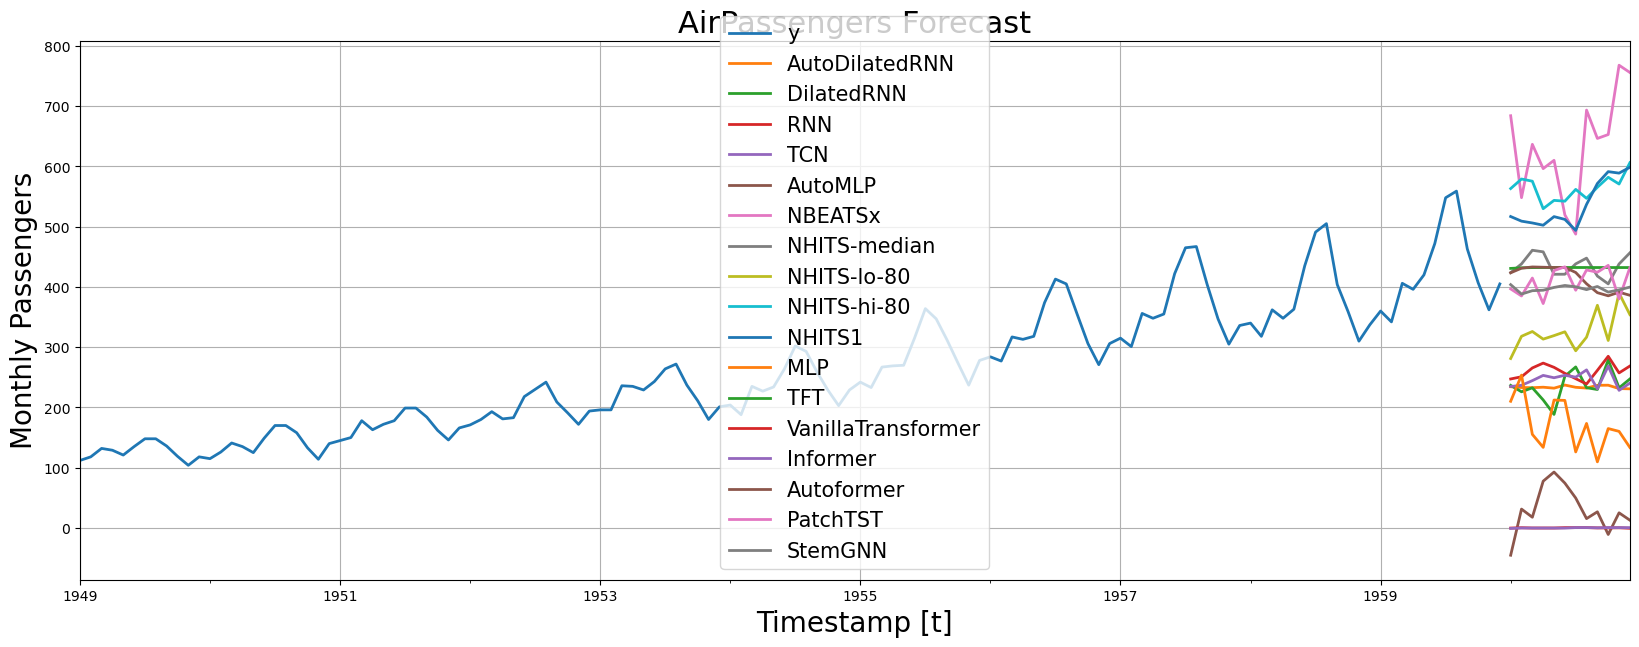

In [23]:
#| hide
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([AirPassengersPanel_train, forecasts.reset_index()]).set_index('ds')

plot_df[plot_df['unique_id']=='Airline1'].drop(['unique_id','trend','y_[lag12]'], axis=1).plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

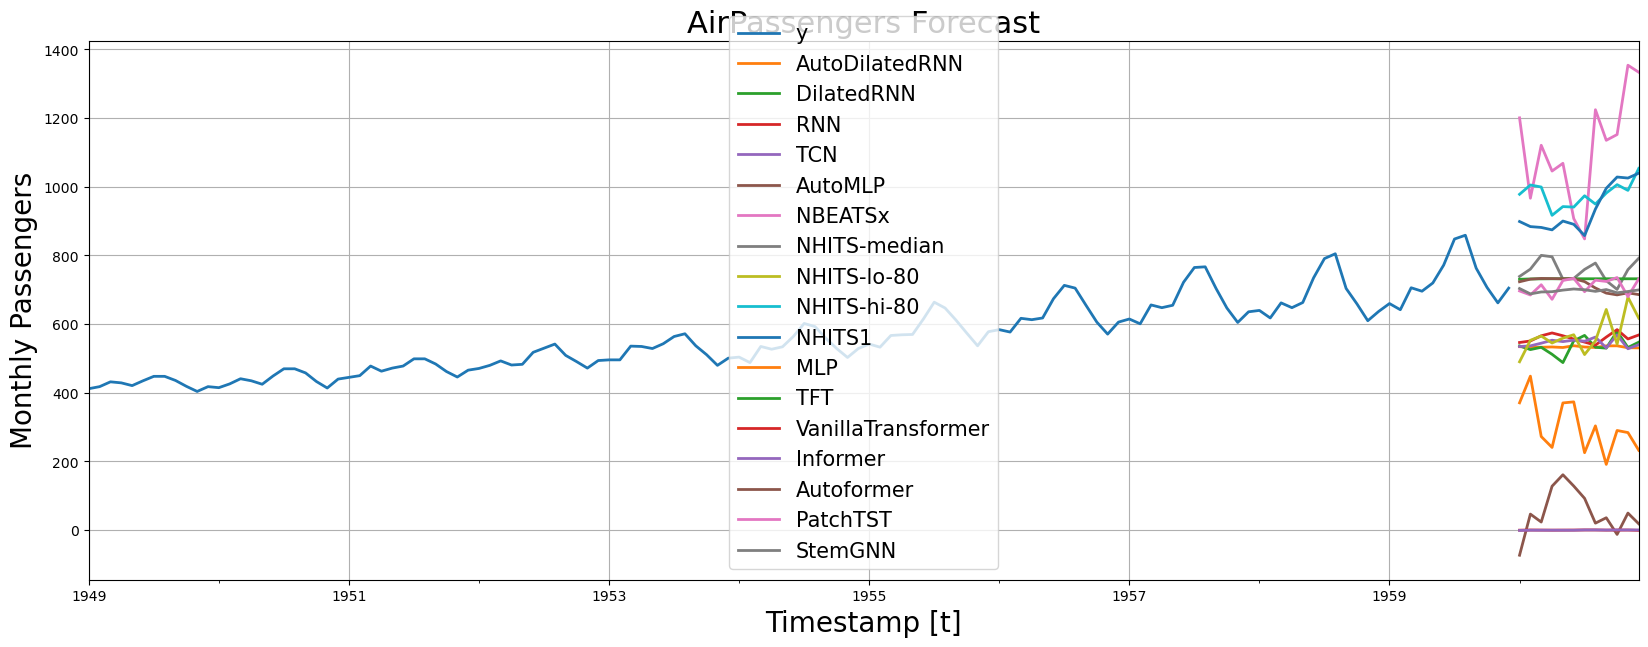

In [24]:
#| hide
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([AirPassengersPanel_train, forecasts.reset_index()]).set_index('ds')

plot_df[plot_df['unique_id']=='Airline2'].drop(['unique_id','trend','y_[lag12]'], axis=1).plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [25]:
#| hide
config = {'input_size': tune.choice([12, 24]), 
          'hidden_size': 256,
          'max_steps': 1,
          'val_check_steps': 1,
          'step_size': 12}

config_drnn = {'input_size': tune.choice([-1]), 
               'encoder_hidden_size': tune.choice([5, 10]),
               'max_steps': 1,
               'val_check_steps': 1,
               'step_size': 1}

fcst = NeuralForecast(
    models=[
        DilatedRNN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1),
        AutoMLP(h=12, config=config, cpus=1, num_samples=1),
        NHITS(h=12, input_size=12, max_steps=1)
    ],
    freq='M'
)
cv_df = fcst.cross_validation(df=AirPassengersPanel, static_df=AirPassengersStatic, n_windows=3, step_size=1)

(train_tune pid=26009) Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s] 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


Global seed set to 1


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 56.41it/s, v_num=0, train_loss_step=425.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 30.40it/s, v_num=0, train_loss_step=425.0, valid_loss=533.0, train_loss_epoch=425.0]
                                                                            

(train_tune pid=26009) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=26009)   warnings.warn('resource_tracker: There appear to be %d '


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.21it/s]


In [26]:
#| hide
#test cross validation no leakage
def test_cross_validation(df, static_df, h, test_size):
    if (test_size - h) % 1:
        raise Exception("`test_size - h` should be module `step_size`")
    
    n_windows = int((test_size - h) / 1) + 1
    Y_test_df = df.groupby('unique_id').tail(test_size)
    Y_train_df = df.drop(Y_test_df.index)
    config = {'input_size': tune.choice([12, 24]),
              'step_size': 12, 'hidden_size': 256, 'max_steps': 1, 'val_check_steps': 1}
    config_drnn = {'input_size': tune.choice([-1]), 'encoder_hidden_size': tune.choice([5, 10]),
                   'max_steps': 1, 'val_check_steps': 1}
    fcst = NeuralForecast(
        models=[
            AutoDilatedRNN(h=12, config=config_drnn, cpus=1, num_samples=1),
            DilatedRNN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1),
            RNN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1,
                stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            TCN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1,
                stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            AutoMLP(h=12, config=config, cpus=1, num_samples=1),
            MLP(h=12, input_size=12, max_steps=1, scaler_type='robust'),
            NBEATSx(h=12, input_size=12, max_steps=1,
                    stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            NHITS(h=12, input_size=12, max_steps=1, scaler_type='robust'),
            NHITS(h=12, input_size=12, loss=MQLoss(level=[80]), max_steps=1),
            TFT(h=12, input_size=24, max_steps=1, scaler_type='robust'),
            VanillaTransformer(h=12, input_size=12, max_steps=1, scaler_type=None),
            Informer(h=12, input_size=12, max_steps=1, scaler_type=None),
            Autoformer(h=12, input_size=12, max_steps=1, scaler_type=None),
            PatchTST(h=12, input_size=24, max_steps=1, scaler_type=None),
            StemGNN(h=12, input_size=12, n_series=2, max_steps=1, scaler_type='robust')
        ],
        freq='M'
    )
    fcst.fit(df=Y_train_df, static_df=static_df)
    Y_hat_df = fcst.predict(futr_df=Y_test_df)
    Y_hat_df = Y_hat_df.merge(Y_test_df, how='left', on=['unique_id', 'ds'])
    last_dates = Y_train_df.groupby('unique_id').tail(1)
    last_dates = last_dates[['unique_id', 'ds']].rename(columns={'ds': 'cutoff'})
    Y_hat_df = Y_hat_df.merge(last_dates, how='left', on='unique_id')
    
    #cross validation
    fcst = NeuralForecast(
        models=[
            AutoDilatedRNN(h=12, config=config_drnn, cpus=1, num_samples=1),
            DilatedRNN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1),
            RNN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1,
                stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            TCN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1,
                stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            AutoMLP(h=12, config=config, cpus=1, num_samples=1),
            MLP(h=12, input_size=12, max_steps=1, scaler_type='robust'),
            NBEATSx(h=12, input_size=12, max_steps=1,
                    stat_exog_list=['airline1'], futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
            NHITS(h=12, input_size=12, max_steps=1, scaler_type='robust'),
            NHITS(h=12, input_size=12, loss=MQLoss(level=[80]), max_steps=1),
            TFT(h=12, input_size=24, max_steps=1, scaler_type='robust'),
            VanillaTransformer(h=12, input_size=12, max_steps=1, scaler_type=None),
            Informer(h=12, input_size=12, max_steps=1, scaler_type=None),
            Autoformer(h=12, input_size=12, max_steps=1, scaler_type=None),
            PatchTST(h=12, input_size=24, max_steps=1, scaler_type=None),
            StemGNN(h=12, input_size=12, n_series=2, max_steps=1, scaler_type='robust')
        ],
        freq='M'
    )
    Y_hat_df_cv = fcst.cross_validation(df, static_df=static_df, test_size=test_size, 
                                        n_windows=None)
    for col in ['ds', 'cutoff']:
        Y_hat_df_cv[col] = pd.to_datetime(Y_hat_df_cv[col].astype(str))
        Y_hat_df[col] = pd.to_datetime(Y_hat_df[col].astype(str))
    pd.testing.assert_frame_equal(
        Y_hat_df[Y_hat_df_cv.columns],
        Y_hat_df_cv,
        check_dtype=False,
    )

In [27]:
#| hide
test_cross_validation(AirPassengersPanel, AirPassengersStatic, h=12, test_size=12)

(train_tune pid=26043) Global seed set to 1


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


Global seed set to 1


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 62.11it/s, v_num=0, train_loss_step=435.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s, v_num=201, train_loss_step=435.0, valid_loss=540.0, train_loss_epoch=435.0]

(train_tune pid=26043) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=26043)   warnings.warn('resource_tracker: There appear to be %d '



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.16it/s] 


In [28]:
#| hide
# test save and load
config = {'input_size': tune.choice([12, 24]), 
          'hidden_size': 256,
          'max_steps': 1,
          'val_check_steps': 1,
          'step_size': 12}

config_drnn = {'input_size': tune.choice([-1]),
               'encoder_hidden_size': tune.choice([5, 10]),
               'max_steps': 1,
               'val_check_steps': 1}

fcst = NeuralForecast(
    models=[
        AutoRNN(h=12, config=config_drnn, cpus=1, num_samples=2, refit_with_val=True),
        DilatedRNN(h=12, input_size=-1, encoder_hidden_size=5, max_steps=1),
        AutoMLP(h=12, config=config, cpus=1, num_samples=2),
        NHITS(h=12, input_size=12, max_steps=1,
              futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        StemGNN(h=12, input_size=12, n_series=2, max_steps=1, scaler_type='robust')
    ],
    freq='M'
)
fcst.fit(AirPassengersPanel_train)
forecasts1 = fcst.predict(futr_df=AirPassengersPanel_test)
fcst.save(path='./examples/debug_run/', model_index=None, overwrite=True, save_dataset=True)

(train_tune pid=26067) Global seed set to 1
(train_tune pid=26068) Global seed set to 1


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


Global seed set to 1


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 55.01it/s, v_num=0, train_loss_step=435.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 40.79it/s, v_num=0, train_loss_step=435.0, valid_loss=540.0]
                                                                       
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 46.78it/s, v_num=0, train_loss_step=435.0]train_tune pid=26068) 
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 25.78it/s, v_num=0, train_loss_step=435.0, valid_loss=540.0, train_loss_epoch=435.0]
                                                                            

(train_tune pid=26068) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=26068)   warnings.warn('resource_tracker: There appear to be %d '
(train_tune pid=26067) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=26067)   warnings.warn('resource_tracker: There appear to be %d '


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.94it/s]


In [29]:
#| hide
# test `enable_checkpointing=True` should generate chkpt
shutil.rmtree('lightning_logs')
fcst = NeuralForecast(
    models=[
        MLP(h=12, input_size=12, max_steps=10, val_check_steps=5, enable_checkpointing=True),
        RNN(h=12, input_size=-1, max_steps=10, val_check_steps=5, enable_checkpointing=True)
    ],
    freq='M'
)
fcst.fit(AirPassengersPanel_train)
last_log = f"lightning_logs/{os.listdir('lightning_logs')[-1]}"
no_chkpt_found = ~np.any([file.endswith('checkpoints') for file in os.listdir(last_log)])
test_eq(no_chkpt_found, False)

Global seed set to 1
Global seed set to 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 11.23it/s, v_num=1, train_loss_step=0.608, train_loss_epoch=0.608]


In [30]:
#| hide
# test `enable_checkpointing=False` should not generate chkpt
shutil.rmtree('lightning_logs')
fcst = NeuralForecast(
    models=[
        MLP(h=12, input_size=12, max_steps=10, val_check_steps=5),
        RNN(h=12, input_size=-1, max_steps=10, val_check_steps=5)
    ],
    freq='M'
)
fcst.fit(AirPassengersPanel_train)
last_log = f"lightning_logs/{os.listdir('lightning_logs')[-1]}"
no_chkpt_found = ~np.any([file.endswith('checkpoints') for file in os.listdir(last_log)])
test_eq(no_chkpt_found, True)

Global seed set to 1
Global seed set to 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s, v_num=1, train_loss_step=0.608, train_loss_epoch=0.608]


In [31]:
#| hide
fcst2 = NeuralForecast.load(path='./examples/debug_run/')
forecasts2 = fcst2.predict(futr_df=AirPassengersPanel_test)

Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1
Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.88it/s]


In [32]:
#| hide
pairwise_tuples = [('AutoRNN', 'RNN'), ('DilatedRNN','DilatedRNN'), ('AutoMLP','MLP'), ('NHITS','NHITS'), ('StemGNN','StemGNN')]
for model1, model2 in pairwise_tuples:
    np.allclose(forecasts1[model1], forecasts2[model2])

In [33]:
#| hide
# test short time series
config = {'input_size': tune.choice([12, 24]), 
          'max_steps': 1,
          'val_check_steps': 1}

fcst = NeuralForecast(
    models=[
        AutoNBEATS(h=12, config=config, cpus=1, num_samples=2)],
    freq='M'
)

AirPassengersShort = AirPassengersPanel.tail(36+144).reset_index(drop=True)
forecasts = fcst.cross_validation(AirPassengersShort, val_size=48, n_windows=1)

(train_tune pid=26077) Global seed set to 1
(train_tune pid=26078) Global seed set to 1


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s] 
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


Global seed set to 1
(train_tune pid=26077) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=26077)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s, v_num=0, train_loss_step=39.20]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s, v_num=0, train_loss_step=39.20]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                              

(train_tune pid=26078) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=26078)   warnings.warn('resource_tracker: There appear to be %d '


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.01it/s]


In [34]:
#| hide
# Test predict_rolled equal cross_validation
config = {'input_size': tune.choice([12, 24]), 
          'hidden_size': 256,
          'max_steps': 1,
          'val_check_steps': 1,
          'step_size': 12}

fcst = NeuralForecast(
    models=[
        RNN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1,
            stat_exog_list=['airline1'],
            futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        AutoMLP(h=12, config=config, cpus=1, num_samples=2),
        NHITS(h=12, input_size=12, max_steps=1,
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'], hist_exog_list=['y_[lag12]'])
    ],
    freq='M'
)
fcst.fit(df=AirPassengersPanel_train, static_df=AirPassengersStatic)
cv_df = fcst.cross_validation(df=AirPassengersPanel, static_df=AirPassengersStatic, n_windows=3, step_size=1)
insample_df = fcst.predict_rolled(df=AirPassengersPanel, static_df=AirPassengersStatic, n_windows=3, step_size=1)
pd.testing.assert_frame_equal(
    cv_df,
    insample_df,
    check_dtype=False
)

(train_tune pid=26097) Global seed set to 1
(train_tune pid=26096) Global seed set to 1


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


Global seed set to 1


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 57.91it/s, v_num=0, train_loss_step=425.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 41.12it/s, v_num=0, train_loss_step=425.0, valid_loss=533.0]
                                                                       
                                                                           
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 42.23it/s, v_num=0, train_loss_step=425.0]e pid=26096) 
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 21.45it/s, v_num=0, train_loss_step=425.0, valid_loss=533.0, train_loss_epoch=425.0]
                                                                            

(train_tune pid=26097) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=26097)   warnings.warn('resource_tracker: There appear to be %d '
(train_tune pid=26096) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=26096)   warnings.warn('resource_tracker: There appear to be %d '


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.25it/s] 


In [35]:
#| hide
# Test last window forecasts do not change with n_windows (testing independence of forecasts)
config = {'input_size': tune.choice([12, 24]), 
          'hidden_size': 256,
          'max_steps': 1,
          'val_check_steps': 1,
          'step_size': 12}

fcst = NeuralForecast(
    models=[
        # RNN(h=12, input_size=-1, encoder_hidden_size=10, max_steps=1,
        #     stat_exog_list=['airline1'],
        #     futr_exog_list=['trend'], hist_exog_list=['y_[lag12]']),
        AutoMLP(h=12, config=config, cpus=1, num_samples=2),
        NHITS(h=12, input_size=12, max_steps=1,
              stat_exog_list=['airline1'],
              futr_exog_list=['trend'], hist_exog_list=['y_[lag12]'])
    ],
    freq='M'
)
fcst.fit(df=AirPassengersPanel_train, static_df=AirPassengersStatic)

insample_df2 = fcst.predict_rolled(df=AirPassengersPanel, static_df=AirPassengersStatic, n_windows=2, step_size=1)
insample_df3 = fcst.predict_rolled(df=AirPassengersPanel, static_df=AirPassengersStatic, n_windows=4, step_size=1)

insample_df2 = insample_df2[insample_df2['cutoff']=='1959-12-31'].reset_index(drop=True)
insample_df3 = insample_df3[insample_df3['cutoff']=='1959-12-31'].reset_index(drop=True)

pd.testing.assert_frame_equal(
    insample_df2,
    insample_df3,
    check_dtype=False
)

(train_tune pid=26107) Global seed set to 1
(train_tune pid=26106) Global seed set to 1
Global seed set to 1


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(train_tune pid=26106) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=26106)   warnings.warn('resource_tracker: There appear to be %d '
(train_tune pid=26107) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=26107)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 48.98it/s, v_num=0, train_loss_step=435.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 58.92it/s, v_num=0, train_loss_step=435.0]
Validation: 0it [00:00, ?it/s]0m 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.95it/s]
